# DSLWP-B orbital parameter analysis

In this notebook we analyse the Keplerian orbital parameters derived from the DSLWP-B tracking files published by Wei Mingchuan BG2BHC using GMAT. The ECEF cartesian state is loaded from the first line of the tracking file and then the orbit is propagated and some Keplerian state parameters are plotted to compare the elliptical orbits in different tracking files.

In [1]:
%matplotlib inline

Set this to the path of your GMAT executable:

In [2]:
GMAT_PATH = '/home/daniel/GMAT/R2018a/bin/GMAT-R2018a'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.time import Time

import subprocess

# Larger figure size
fig_size = [10, 6]
plt.rcParams['figure.figsize'] = fig_size

The GMAT script template contains fields ready to be filled in using Python's `format()` function.

In [4]:
gmat_script_template = """
%----------------------------------------
%---------- Spacecraft
%----------------------------------------

Create Spacecraft DSLWP_B;
DSLWP_B.DateFormat = UTCModJulian;
DSLWP_B.Epoch = '{epoch}';
DSLWP_B.CoordinateSystem = EarthFixed;
DSLWP_B.DisplayStateType = Cartesian;
DSLWP_B.X = {x};
DSLWP_B.Y = {y};
DSLWP_B.Z = {z};
DSLWP_B.VX = {vx};
DSLWP_B.VY = {vy};
DSLWP_B.VZ = {vz};
DSLWP_B.DryMass = 45;
DSLWP_B.DragArea = 0.25;
DSLWP_B.SRPArea = 0.25;

%----------------------------------------
%---------- ForceModels
%----------------------------------------

Create ForceModel LunaProp_ForceModel;
LunaProp_ForceModel.CentralBody = Luna;
LunaProp_ForceModel.PrimaryBodies = {{Luna}};
LunaProp_ForceModel.PointMasses = {{Earth, Jupiter, Mars, Neptune, Saturn, Sun, Uranus, Venus}};
LunaProp_ForceModel.Drag = None;
LunaProp_ForceModel.SRP = On;
LunaProp_ForceModel.RelativisticCorrection = On;
LunaProp_ForceModel.ErrorControl = RSSStep;
LunaProp_ForceModel.GravityField.Luna.Degree = 10;
LunaProp_ForceModel.GravityField.Luna.Order = 10;
LunaProp_ForceModel.GravityField.Luna.StmLimit = 100;
LunaProp_ForceModel.GravityField.Luna.PotentialFile = 'LP165P.cof';
LunaProp_ForceModel.GravityField.Luna.TideModel = 'None';

%----------------------------------------
%---------- Propagators
%----------------------------------------

Create Propagator LunaProp;
LunaProp.FM = LunaProp_ForceModel;
LunaProp.Type = PrinceDormand78;
LunaProp.InitialStepSize = 1;
LunaProp.Accuracy = 1e-13;
LunaProp.MinStep = 0;
LunaProp.MaxStep = 600;

%----------------------------------------
%---------- Coordinate Systems
%----------------------------------------

Create CoordinateSystem LunaInertial;
LunaInertial.Origin = Luna;
LunaInertial.Axes = BodyInertial;

%----------------------------------------
%---------- Subscribers
%----------------------------------------

Create OrbitView LunaOrbitView;
GMAT LunaOrbitView.SolverIterations = None;
GMAT LunaOrbitView.UpperLeft = [ 0.1801470588235294 0.04190751445086705 ];
GMAT LunaOrbitView.Size = [ 0.9926470588235294 0.9552023121387283 ];
GMAT LunaOrbitView.RelativeZOrder = 126;
GMAT LunaOrbitView.Maximized = true;
GMAT LunaOrbitView.Add = {{DSLWP_B, Earth, Luna, Sun}};
GMAT LunaOrbitView.CoordinateSystem = LunaInertial;
GMAT LunaOrbitView.DrawObject = [ true true true true ];
GMAT LunaOrbitView.DataCollectFrequency = 1;
GMAT LunaOrbitView.UpdatePlotFrequency = 50;
GMAT LunaOrbitView.NumPointsToRedraw = 0;
GMAT LunaOrbitView.ShowPlot = true;
GMAT LunaOrbitView.MaxPlotPoints = 20000;
GMAT LunaOrbitView.ShowLabels = true;
GMAT LunaOrbitView.ViewPointReference = Luna;
GMAT LunaOrbitView.ViewPointVector = [ 30000 0 0 ];
GMAT LunaOrbitView.ViewDirection = Luna;
GMAT LunaOrbitView.ViewScaleFactor = 1;
GMAT LunaOrbitView.ViewUpCoordinateSystem = LunaInertial;
GMAT LunaOrbitView.ViewUpAxis = Z;
GMAT LunaOrbitView.EclipticPlane = Off;
GMAT LunaOrbitView.XYPlane = On;
GMAT LunaOrbitView.WireFrame = Off;
GMAT LunaOrbitView.Axes = On;
GMAT LunaOrbitView.Grid = Off;
GMAT LunaOrbitView.SunLine = Off;
GMAT LunaOrbitView.UseInitialView = On;
GMAT LunaOrbitView.StarCount = 7000;
GMAT LunaOrbitView.EnableStars = On;
GMAT LunaOrbitView.EnableConstellations = Off;

Create ReportFile OrbitReport;
OrbitReport.Filename = '/home/daniel/jupyter_notebooks/dslwp/OrbitReport_{label}.txt';
OrbitReport.Add = {{DSLWP_B.UTCModJulian, DSLWP_B.Luna.SMA, DSLWP_B.Luna.ECC, DSLWP_B.LunaInertial.INC, DSLWP_B.LunaInertial.RAAN, DSLWP_B.LunaInertial.AOP, DSLWP_B.Luna.MA, DSLWP_B.Luna.TA}};
OrbitReport.WriteHeaders = false;
OrbitReport.WriteReport = true;


%----------------------------------------
%---------- Mission Sequence
%----------------------------------------

BeginMissionSequence;
Toggle OrbitReport Off
If DSLWP_B.UTCModJulian <= {start}
    Propagate LunaProp(DSLWP_B) {{DSLWP_B.UTCModJulian = {start}}}
Else
    Propagate BackProp LunaProp(DSLWP_B) {{DSLWP_B.UTCModJulian = {start}}}
EndIf
Toggle OrbitReport On
Propagate LunaProp(DSLWP_B) {{DSLWP_B.UTCModJulian = {end}}}
"""

Conversion between UNIX timestamp (used by the tracking files) and GMAT Modified Julian Day.

In [5]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

def unixtimestamp2mjd(u):
    return u / seconds_in_day + mjd_unixtimestamp_offset

In [6]:
unixtimestamp2mjd(1528607994)

28279.722152777777

Utility function to load the first row from a tracking file and to load the Keplerian state report from GMAT.

In [7]:
def load_tracking_file(path):
    ncols = 7
    data = np.fromfile(path, sep=' ', count=ncols)
    return data

def load_orbit_file(path):
    ncols = 8
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

Keys for each of the columns in the orbit (Keplerian state) report.

In [8]:
utc = 0
sma = 1
ecc = 2
inc = 3
raan = 4
aop = 5
ma = 6
ta = 7

The function below takes the data from a tracking file, generates a GMAT script and executes it. GMAT is closed automatically after the script has run unless `do_not_close` is set to `True`. This can be useful to examine the simulation output in more detail.

In [9]:
def gmat_propagate_tracking(track, start, end, label = '', do_not_close = False):
    data = {'label' : label, 'start' : start, 'end' : end}
    data['epoch'] = unixtimestamp2mjd(track[0])
    data['x'], data['y'], data['z'] = track[1:4]
    data['vx'], data['vy'], data['vz'] = track[4:7]
    SCRIPT_PATH = '/tmp/gmat.script'
    with open(SCRIPT_PATH, 'w') as f:
        f.write(gmat_script_template.format(**data))
    subprocess.call([GMAT_PATH, '-r', SCRIPT_PATH] + (['-x'] if not do_not_close else []))

Load the cartesian state from each tracking file, propagate the orbit and write a Keplerian state report using GMAT.

In [10]:
#parts = ['20180526', '20180528', '20180529', '20180531', '20180601', '20180602', '20180603', '20180607', '20180609']
#parts = ['20180602', '20180603', '20180607', '20180609', '20180610', '20180615', '20180619', '20180622']
#parts = ['20180610', '20180615', '20180619', '20180622']
parts = ['20180629', '20180714', '20180727a']
parts = ['20180727a']
parts = ['20180622']
parts = ['20180727a', '20180803', '20180812', '20180814', '20180816', '20180818']
parts = ['20180812', '20180912', '20180914', '20180916', '20180930', '20181004', '20181006']
parts = ['20180812', '20180912', '20180914', '20180916', '20180930', '20181004', '20181006']
parts = ['20181006', '20181008', '20181010', '20181013', '20181015', '20181017', '20181019', '20181021']
parts = ['20181019']
parts = ['20190317']
parts = ['20190426']
parts = ['20190520']
parts = ['20190603']
parts = ['20190630']

for part in parts:
    tracking = load_tracking_file('tracking_files/program_tracking_dslwp-b_{}.txt'.format(part))
    gmat_propagate_tracking(tracking, start = '28560', end = '28570', label = part)

Plot the orbital parameters which are vary significantly between different tracking files.

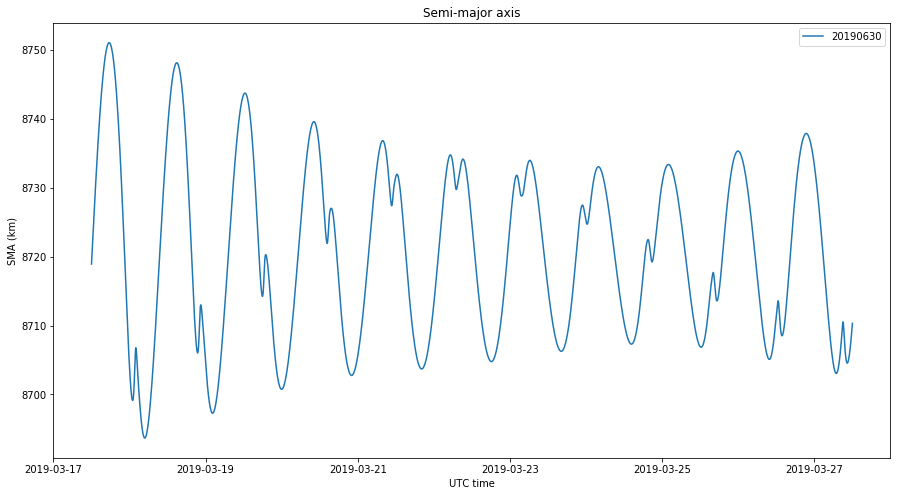

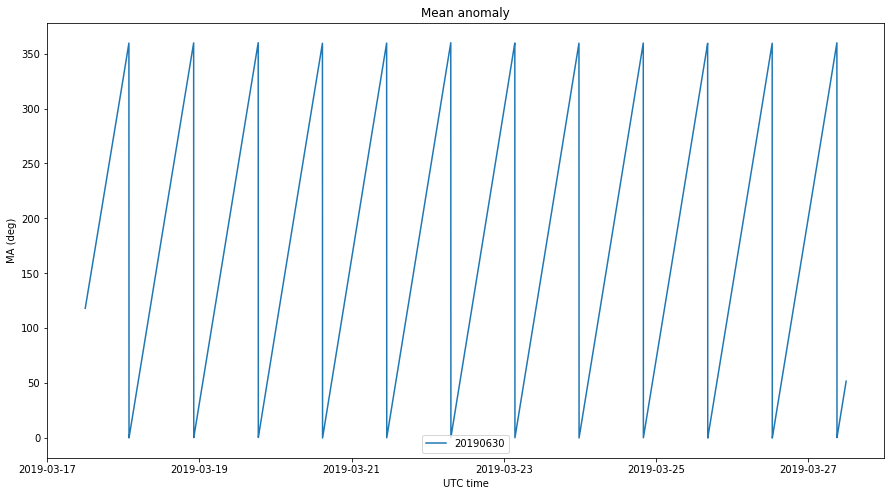

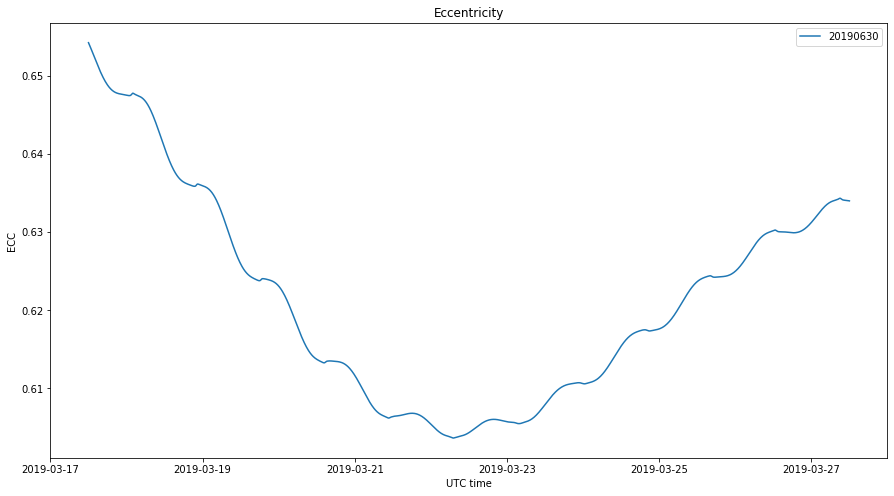

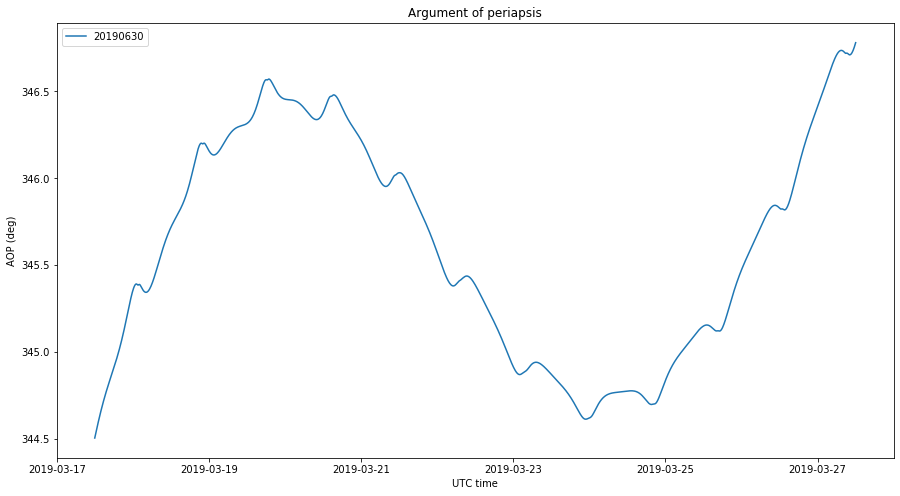

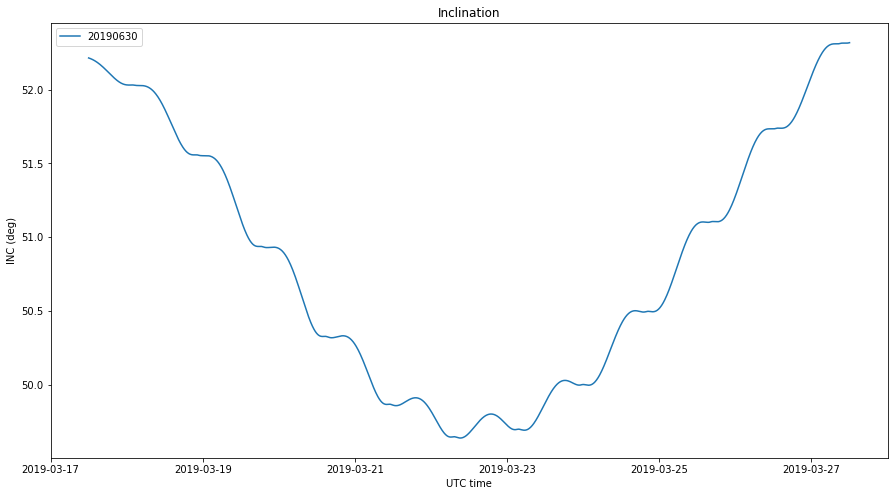

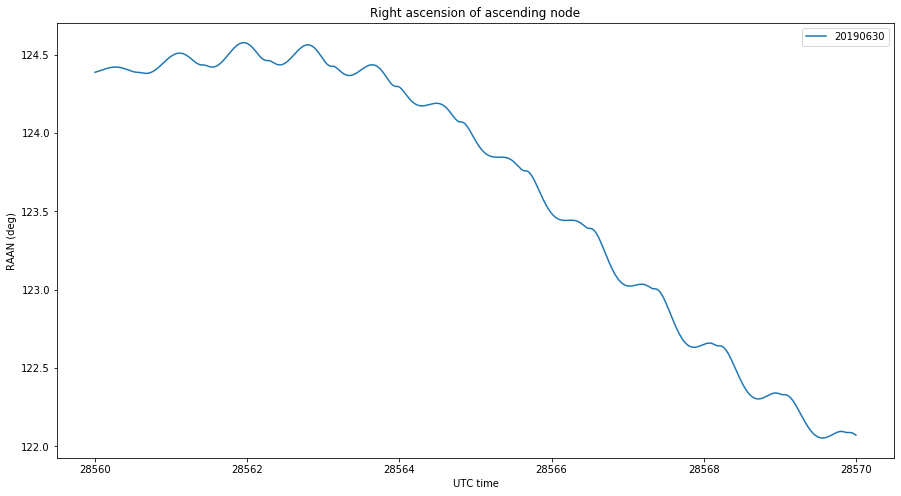

In [11]:
fig1 = plt.figure(figsize = [15,8], facecolor='w')
fig2 = plt.figure(figsize = [15,8], facecolor='w')
fig3 = plt.figure(figsize = [15,8], facecolor='w')
fig4 = plt.figure(figsize = [15,8], facecolor='w')
fig5 = plt.figure(figsize = [15,8], facecolor='w')
fig6 = plt.figure(figsize = [15,8], facecolor='w')
sub1 = fig1.add_subplot(111)
sub2 = fig2.add_subplot(111)
sub3 = fig3.add_subplot(111)
sub4 = fig4.add_subplot(111)
sub5 = fig5.add_subplot(111)
sub6 = fig6.add_subplot(111)
for part in parts:
    orbit = load_orbit_file('OrbitReport_{}.txt'.format(part))
    t = Time(mjd2unixtimestamp(orbit[:,utc]), format='unix')
    sub1.plot(t.datetime, orbit[:,sma])
    sub2.plot(t.datetime, orbit[:,ma])
    sub3.plot(t.datetime, orbit[:,ecc])
    sub4.plot(t.datetime, orbit[:,aop])
    sub5.plot(t.datetime, orbit[:,inc])
    sub6.plot(orbit[:,utc], orbit[:,raan])
sub1.legend(parts)
sub2.legend(parts)
sub3.legend(parts)
sub4.legend(parts)
sub5.legend(parts)
sub6.legend(parts)
sub1.set_xlabel('UTC time')
sub2.set_xlabel('UTC time')
sub3.set_xlabel('UTC time')
sub4.set_xlabel('UTC time')
sub5.set_xlabel('UTC time')
sub6.set_xlabel('UTC time')
sub1.set_ylabel('SMA (km)')
sub2.set_ylabel('MA (deg)')
sub3.set_ylabel('ECC')
sub4.set_ylabel('AOP (deg)')
sub5.set_ylabel('INC (deg)')
sub6.set_ylabel('RAAN (deg)')
sub1.set_title('Semi-major axis')
sub2.set_title('Mean anomaly')
sub3.set_title('Eccentricity')
sub4.set_title('Argument of periapsis')
sub5.set_title('Inclination')
sub6.set_title('Right ascension of ascending node');

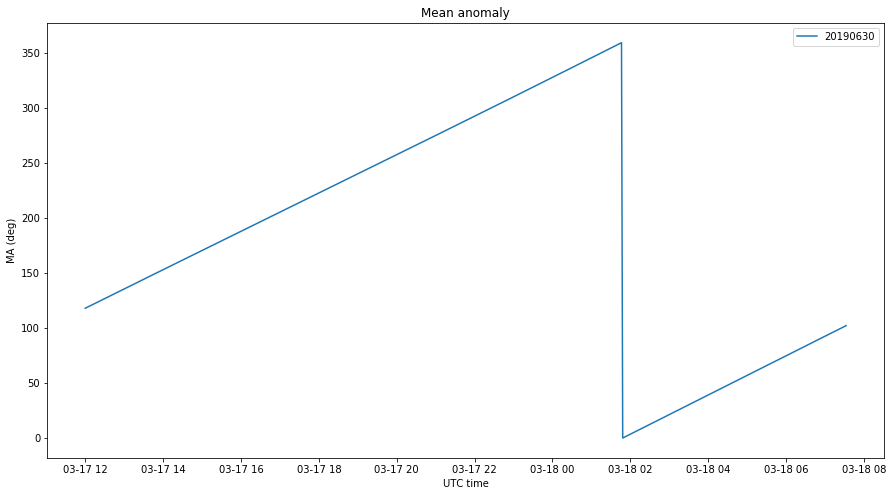

In [12]:
plt.figure(figsize = [15,8], facecolor='w')
for part in parts:
    orbit = load_orbit_file('OrbitReport_{}.txt'.format(part))
    t = Time(mjd2unixtimestamp(orbit[:,utc]), format='unix')
    plt.plot(t[:200].datetime, orbit[:200,ma])
plt.legend(parts)
plt.xlabel('UTC time')
plt.ylabel('MA (deg)')
plt.title('Mean anomaly');